In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data_loader import read_data
from PIL import Image
import json 
import clip.clip as clip 
from src.networks.CLIP_distilBERT_unfreeze import CLIP_dBERT_unfreezed_layers_dataset,CLIP_dBERT_unfreezed_layers_Input_transformer, CLIP_dBERT_unfreezed_layers_Model
import torch 
import re 
from src.CONST import NUM_LABELS
import sys 
import numpy as np 
from src.CONST import REVERSE_ONE_HOT_ENCODING
test_data = read_data('test')

100%|██████████| 200/200 [00:00<00:00, 2476.94it/s]


In [3]:
import clip.clip as clip 

CLIP_MODEL,  clip_img_processor =clip.load('ViT-B/32', jit=False)

In [4]:
from src.config import BATCH_SIZE
import random 
import numpy as np 
import torch 

from src.networks.CLIP_distilBERT_unfreeze import CLIP_dBERT_unfreezed_layers_dataset

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)

def get_dataloader(data):
    dataset = CLIP_dBERT_unfreezed_layers_dataset(data, clip_img_processor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True, worker_init_fn=seed_worker, generator=g)
    return data_loader
    
test_loader = get_dataloader(test_data)

CLIP preprocessing: 100%|██████████| 200/200 [00:03<00:00, 54.38it/s]


In [5]:
def get_text():
    Data = {}
    Images = []
    for dataset_type in ['test', 'train', 'val']:
        with open(f'Data/annotations/{dataset_type}.jsonl', 'r',encoding='utf8') as json_file:
            json_list = list(json_file)
        for json_str in json_list:
            data_point = json.loads(json_str)
            Data[ data_point['image'] ] = data_point['text']
            Images.append( data_point['image'] )

    return Data, set(Images)

def pretty_string(y_pred):
    techniques = []
    y_pred = y_pred.squeeze()
    for i in range(22):
        if y_pred[i] == 1:
            techniques.append(REVERSE_ONE_HOT_ENCODING[i])
    return techniques

def clean_text(text):
  text = text.replace("\n", " ")
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  return text

def predict(image_name,model):
    image_path = f"Data/images/{image_name}"
    img = Image.open(image_path)
    text = clean_text( Data_text[image_name] )
    dummy_encoding = np.zeros((NUM_LABELS,))
    data_point = {}
    data_point['text'] = text 
    data_point['image_PIL'] = img 
    data_point['encoded_labels'] = dummy_encoding
    dataset = CLIP_dBERT_unfreezed_layers_dataset([data_point], clip_img_processor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1)
    input_transformer = CLIP_dBERT_unfreezed_layers_Input_transformer()
    for x,y in loader:
        x,_ = input_transformer.transform(x,y)
        _, y_pred = model(*x)
        return pretty_string(y_pred)
    print("SHOULD NOT REACH HERE")
    sys.exit(-1)

def get_labels(uploaded_file,model):
    name = uploaded_file.split('/')[-1]
    if name not in Images_list:
        return "Please select from test data. OCR limitation"
        sys.exit(-1)
    return predict(name, model)

In [6]:
Data_text, Images_list = get_text()

In [7]:
from src.networks.CLIP_distilBERT_unfreeze import CLIP_dBERT_unfreezed_layers_Input_transformer, CLIP_dBERT_unfreezed_layers_Model
model = CLIP_dBERT_unfreezed_layers_Model(CLIP_MODEL)
model.load_state_dict( torch.load('Models/CLIP_distilBERT_unfreeze.model') )
model = model.cuda()
model = model.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Unfreezing - transformer.layer.5.attention.q_lin.weight
Unfreezing - transformer.layer.5.attention.q_lin.bias
Unfreezing - transformer.layer.5.attention.k_lin.weight
Unfreezing - transformer.layer.5.attention.k_lin.bias
Unfreezing - transformer.layer.5.attention.v_lin.weight
Unfreezing - transformer.layer.5.attention.v_lin.bias
Unfreezing - transformer.layer.5.attention.out_lin.weight
Unfreezing - transformer.layer.5.attention.out_lin.bias
Unfreezing - transformer.layer.5.sa_layer_norm.weight
Unfreezing - transformer.layer.5.sa_layer_norm.bias
Unfreezing - transformer.layer.5.ffn.lin1.weight
Unfreezing - transformer.layer.5.ffn.lin1.bias
Unfreezing - transformer.layer.5.ffn.lin2.weight
Unfreezing - transformer.layer.5.ffn.lin2.bias
Unfreezing - transformer.layer.5.output_layer_norm.weight
Unfreezing - transformer.layer.5.output_layer_norm.bias


In [8]:
file_path = f"Data/images/1_image.png"
image = Image.open(file_path)

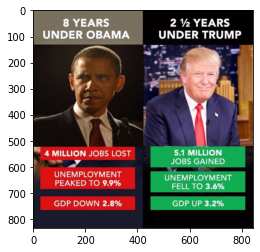

In [9]:
from matplotlib.pyplot import imshow
imshow(np.asarray(image))


In [10]:
labels = get_labels(file_path,model)

In [11]:
print(labels)

Please select from test data. OCR limitation
